In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os

In [3]:
parent_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(parent_dir)

In [4]:
from src import model
from src import utils

In [5]:
import numpy as np
import pandas as pd
import scipy
import datetime

In [6]:
import pymc3 as pm

In [7]:
import theano.tensor as tt

In [8]:
import matplotlib.pyplot as plt

In [10]:
n_series = 10
n_years = 3

In [11]:
df = utils.random_timeseries(n_series=n_series, n_years=n_years)

scalers = {}

for col in [col for col in df.columns if col[0] in ['t', 'y']]:
    
    scaler = utils.MinMaxScaler()
    df[col] = scaler.fit_transform(df[col])
    
    scalers[col] = scaler

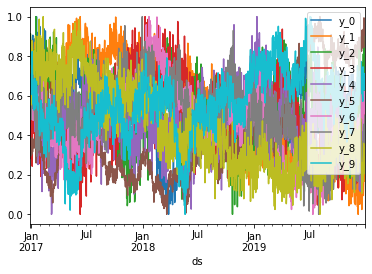

In [12]:
df.set_index(df['ds']).drop(columns=['t', 'ds']).plot()

In [13]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [14]:
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

In [15]:
df_stack = df.set_index([df['t'], df['ds']], drop=True).drop(columns=['t', 'ds']).stack()

y = df_stack.values
t = np.array([x[0] for x in df_stack.index.values])
ds = np.array([x[1] for x in df_stack.index.values])
idx = np.array([int(x[2][2]) for x in df_stack.index.values])

In [16]:
n_changepoints = 10
n_fourier_yearly = 10
n_fourier_weekly = 3

s = np.linspace(0, 0.8 * np.max(t), n_changepoints + 1)[1:]

# * 1 casts the boolean to integers
# A is a boolean matrix specifying which observation time stamps (vector t) --> rows
# have surpasses which changepoint time stamps (vector s) --> columns
A = (t[:, None] > s) * 1

F_yearly = fourier_series(t, scalers['t'].transform(365.25), n_fourier_yearly) # Seasonality w/ yearly period
F_weekly = fourier_series(t, scalers['t'].transform(7), n_fourier_weekly) # Seasonality w/ weekly period

In [17]:
print("F_yearly: ", F_yearly.shape)
print("F_weekly: ", F_weekly.shape)
print("A: ", A.shape)
print("t: ", t.shape)

F_yearly:  (10960, 20)
F_weekly:  (10960, 6)
A:  (10960, 10)
t:  (10960,)


In [18]:
# Generate a PyMC3 Model context
model = pm.Model()

with model:
    
    # HYPER PRIORS
    
    k_mu = pm.Normal('k_mu', mu=0., sd=10)
    k_sigma = pm.HalfCauchy('k_sigma', testval=1, beta=5)
    
    m_mu = pm.Normal('m_mu', mu=0., sd=10)
    m_sigma = pm.HalfCauchy('m_sigma', testval=1, beta=5)
    
    delta_b = pm.HalfCauchy('delta_b', testval=0.1, beta=0.2)
    
    beta_yearly_mu = pm.Normal('beta_yearly_mu', mu=0., sd=3) # Prophet: sd=10
    beta_yearly_sigma = pm.HalfCauchy('beta_yearly_sigma', testval=1, beta=2) # Prophet: beta=5
    
    beta_weekly_mu = pm.Normal('beta_weekly_mu', mu=0., sd=3) # Prophet: sd=10
    beta_weekly_sigma = pm.HalfCauchy('beta_weekly_sigma', testval=1, beta=2) # Prophet: beta=5
    
    # PRIORS
    
    k = pm.Normal('k', k_mu, k_sigma, shape=n_series)
    m = pm.Normal('m', m_mu, m_sigma, shape=n_series)
    delta = pm.Laplace('delta', 0, delta_b, shape = (n_series, n_changepoints))
    beta_yearly = pm.Normal('beta_yearly', beta_yearly_mu, beta_yearly_sigma, 
                            shape = (n_fourier_yearly * 2, n_series))
    beta_weekly = pm.Normal('beta_weekly', beta_weekly_mu, beta_weekly_sigma, 
                            shape = (n_fourier_weekly * 2, n_series))
    
    # tt.printing.Print('1')(A * delta[idx, :])
    
    # Starting point (offset)
    mu = m[idx]
    
    # Linear trend w/ changepoints
    gamma = -s * delta[idx, :]
    mu += (k[idx] + (A * delta[idx, :]).sum(axis=1)) * t + (A * gamma).sum(axis=1) 
    
    # Seasonality
    mu += (F_yearly * beta_yearly[:, idx].T).sum(axis=-1)
    mu += (F_weekly * beta_weekly[:, idx].T).sum(axis=-1)
    
    # Likelihood
    sigma = pm.HalfCauchy('sigma', 1, testval=1, shape=n_series)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma[idx], observed=y)  

In [19]:
with model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, delta, m, k, beta_weekly_sigma, beta_weekly_mu, beta_yearly_sigma, beta_yearly_mu, delta_b, m_sigma, m_mu, k_sigma, k_mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [2:39:15<00:00,  2.39s/draws]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f676983ba50>,
      dtype=object)

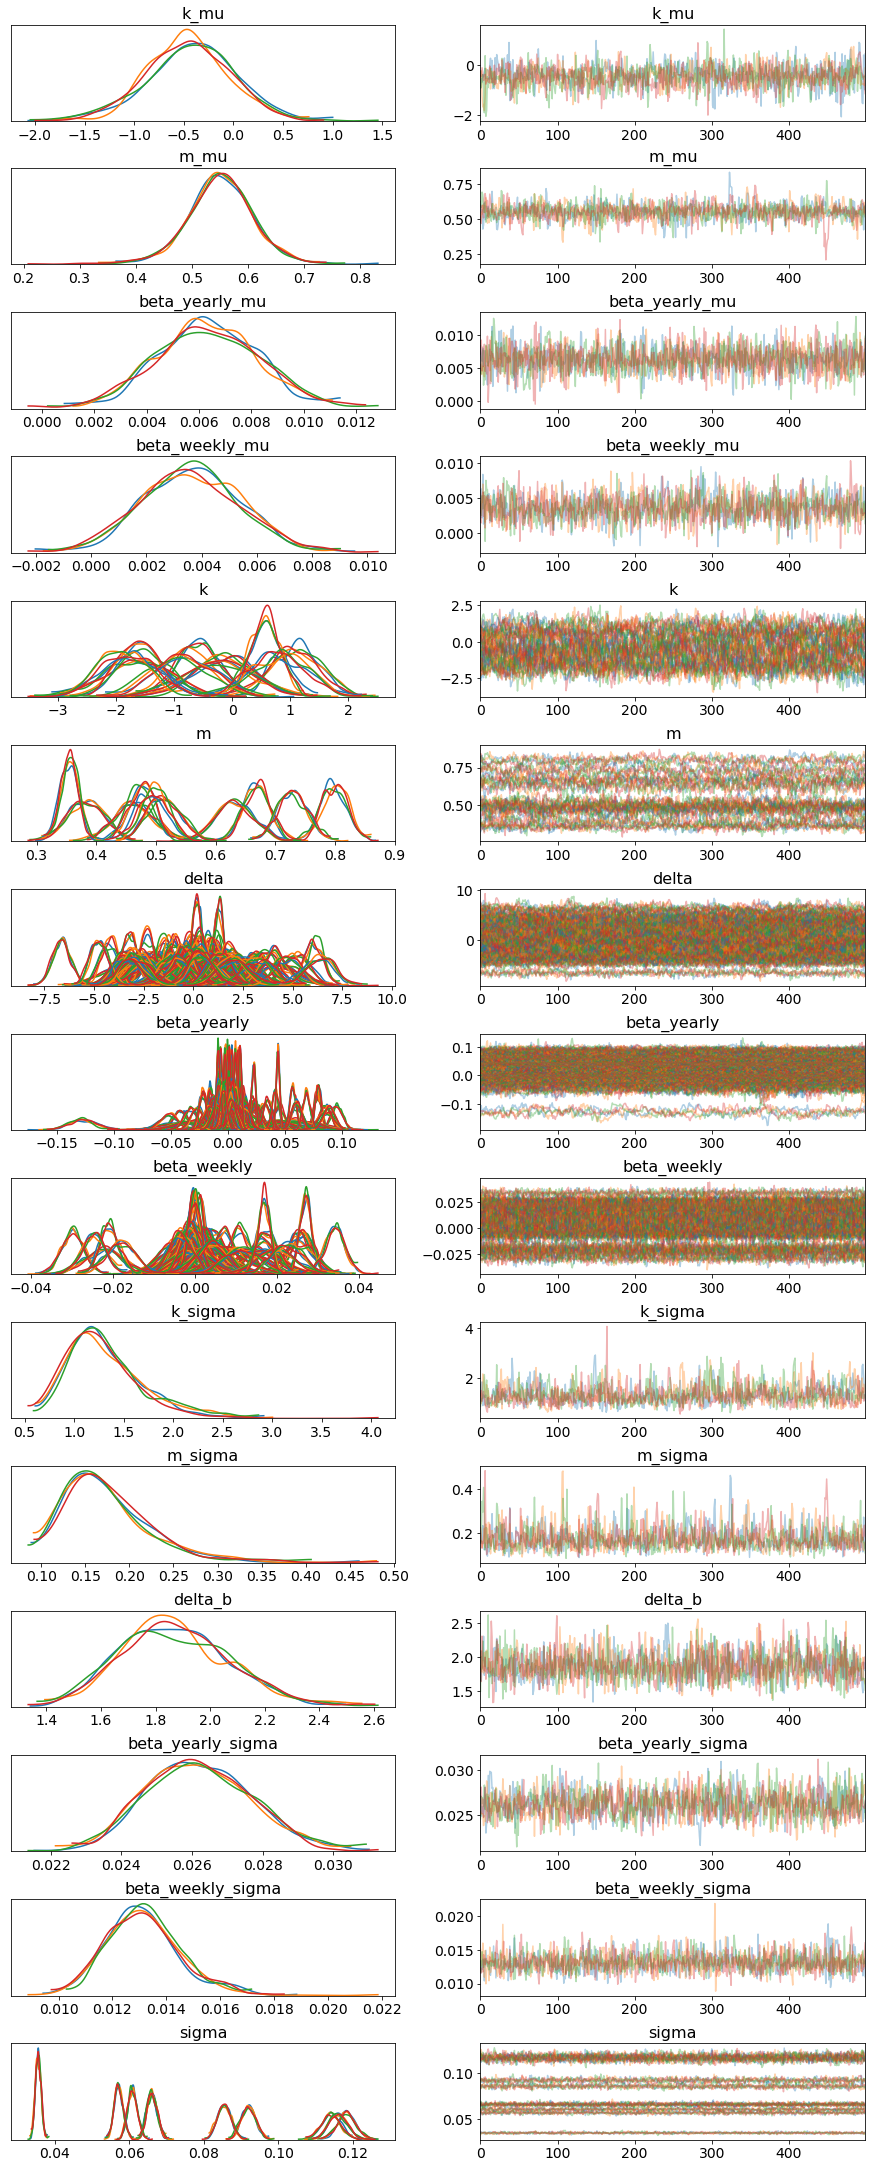

In [20]:
pm.traceplot(trace)

In [21]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
tr_beta_yearly = trace['beta_yearly']
tr_beta_weekly = trace['beta_weekly']
tr_delta = trace['delta']

# scalar distributions
tr_k = trace['k']
tr_m = trace['m']

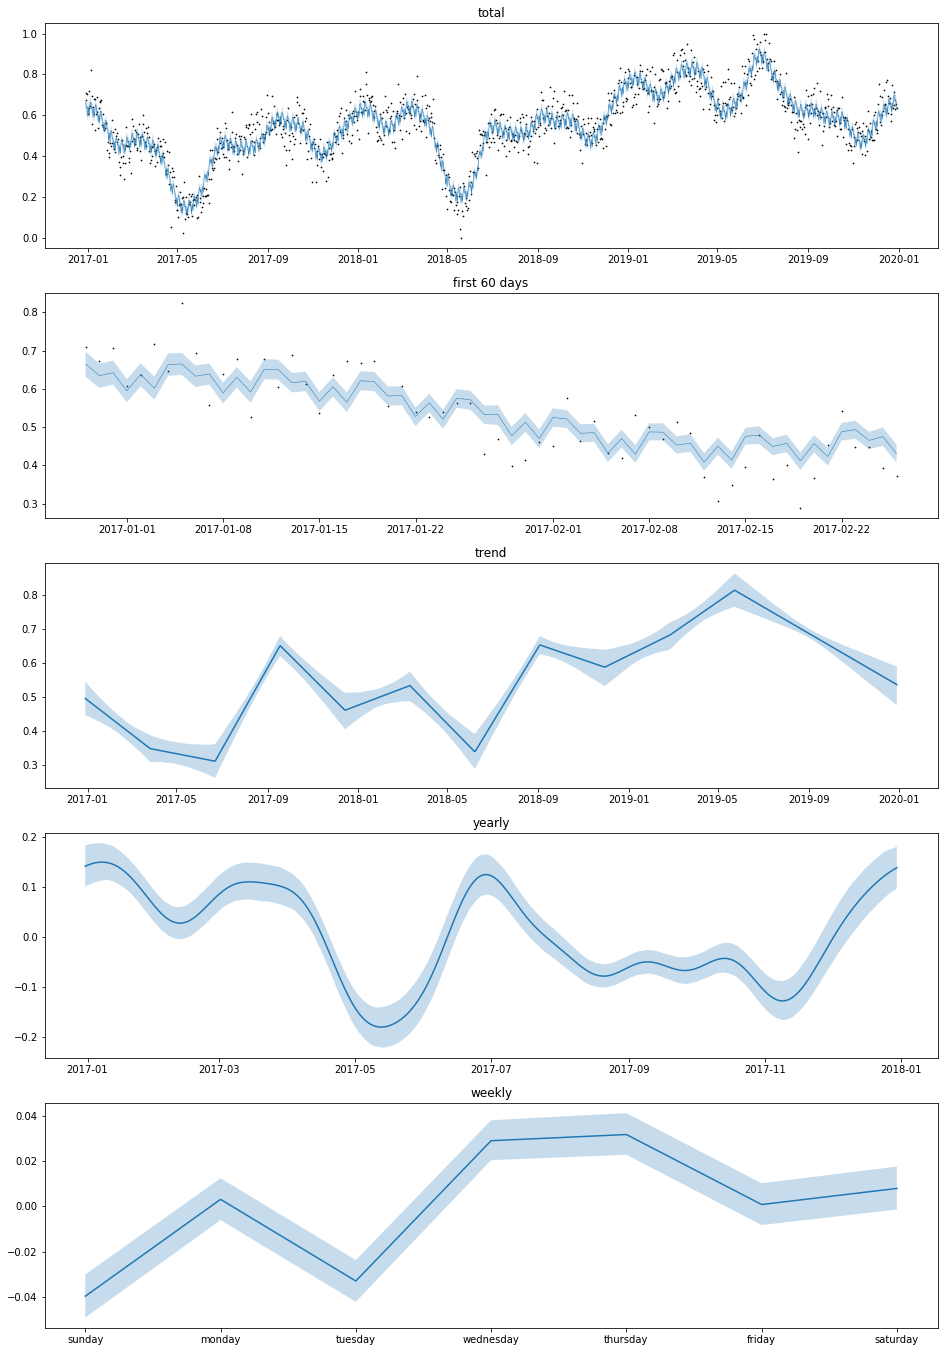

In [39]:
idx_series = 9

series_ds = ds[idx==idx_series]
series_beta_yearly = tr_beta_yearly[:,:,idx_series]
series_beta_weekly = tr_beta_weekly[:,:,idx_series]
series_t = t[idx==idx_series]
series_A = A[idx==idx_series, :]
series_F_yearly = F_yearly[idx==idx_series,:]
series_F_weekly = F_weekly[idx==idx_series,:]
series_delta = tr_delta[:, idx_series, :]
series_k = tr_k[:, idx_series]
series_m = tr_m[:, idx_series]

# determine the posterior by evaulating all the values in the trace.
trend_posterior = (series_k + np.dot(series_A, series_delta.T)) * series_t[:, None] 
trend_posterior += series_m + np.dot(series_A, (-s * series_delta).T)

seasonality_yearly = det_seasonality_posterior(series_beta_yearly, series_F_yearly)
seasonality_weekly = det_seasonality_posterior(series_beta_weekly, series_F_weekly)

fitted = (trend_posterior + seasonality_yearly + seasonality_weekly)

date = pd.Series(series_ds)
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

# Plots

plt.figure(figsize=(16, 4*6))
b = 511
plt.subplot(b)
plt.title('total')
plt.plot(date, fitted.mean(1), lw=0.5)
plt.scatter(df['ds'], df['y_{}'.format(idx_series)], s=0.5, color='black')
quant = np.quantile(fitted, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

n_days = 60
plt.subplot(b + 1)
plt.title('first {} days'.format(n_days))
plt.plot(date[:n_days], fitted.mean(1)[:n_days], lw=0.5)
plt.scatter(df['ds'][:n_days], df['y_{}'.format(idx_series)][:n_days], s=0.5, color='black')
quant = np.quantile(fitted[:n_days, :], [p, 1 - p], axis=1)
plt.fill_between(date[:n_days], quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 3)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], seasonality_yearly.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(seasonality_yearly, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 4)
plt.title('weekly')
plt.plot(weekdays, seasonality_weekly.mean(1)[sunday: sunday + 7])
quant = np.quantile(seasonality_weekly, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

In [41]:
# Find a point estimate of the models parameters
with model:
    approx = pm.find_MAP()

logp = 13,220, ||grad|| = 17.372: 100%|██████████| 3041/3041 [00:25<00:00, 118.54it/s]


In [42]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
pe_beta_yearly = approx['beta_yearly']
pe_beta_weekly = approx['beta_weekly']
pe_delta = approx['delta']

# scalar distributions
pe_k = approx['k']
pe_m = approx['m']

/home/bart/Documents/slimmer/experiments/hierarchical_prophet/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


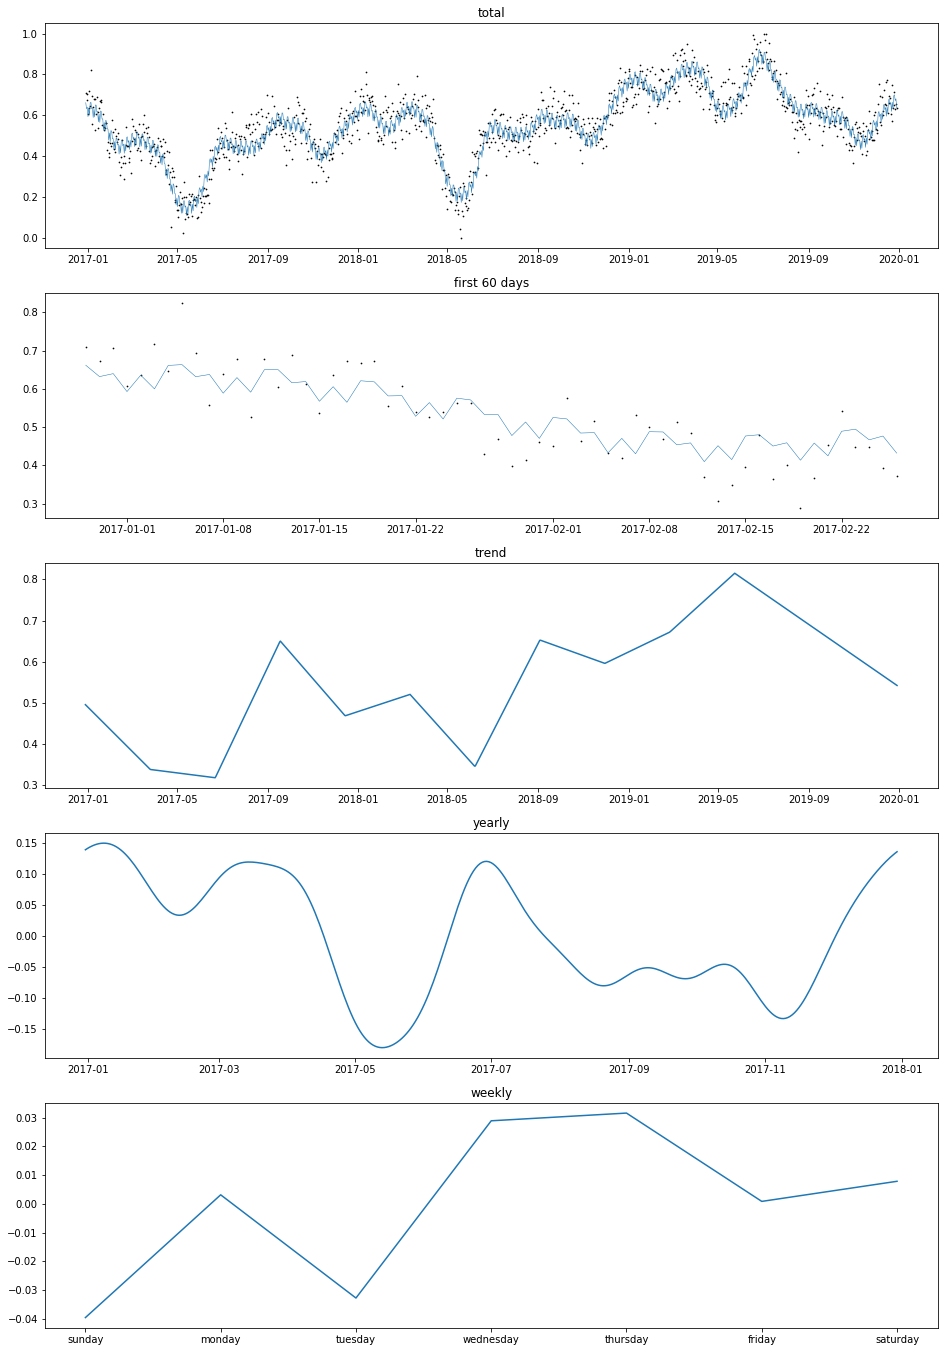

In [43]:
idx_series = 9

series_ds = ds[idx==idx_series]
series_beta_yearly = pe_beta_yearly[:,idx_series]
series_beta_weekly = pe_beta_weekly[:,idx_series]
series_t = t[idx==idx_series]
series_A = A[idx==idx_series, :]
series_F_yearly = F_yearly[idx==idx_series,:]
series_F_weekly = F_weekly[idx==idx_series,:]

# determine the posterior by evaulating all the values in the trace.
trend_posterior = (pe_k[idx_series] + np.dot(series_A, pe_delta[idx_series, :].T)) * series_t 
trend_posterior += pe_m[idx_series] + np.dot(series_A, (-s * pe_delta[idx_series, :]).T)

seasonality_yearly = det_seasonality_posterior(series_beta_yearly, series_F_yearly)
seasonality_weekly = det_seasonality_posterior(series_beta_weekly, series_F_weekly)

fitted = (trend_posterior + seasonality_yearly + seasonality_weekly) #.mean(1)

date = pd.Series(series_ds)
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 4*6))
b = 511
plt.subplot(b)
plt.title('total')
plt.plot(date, fitted, lw=0.5)
plt.scatter(df['ds'], df['y_{}'.format(idx_series)], s=0.5, color='black')

n_days = 60
plt.subplot(b + 1)
plt.title('first {} days'.format(n_days))
plt.plot(date[:n_days], fitted[:n_days], lw=0.5)
plt.scatter(df['ds'][:n_days], df['y_{}'.format(idx_series)][:n_days], s=0.5, color='black')

plt.subplot(b + 2)
plt.title('trend')
plt.plot(date, trend_posterior[:])

plt.subplot(b + 3)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], seasonality_yearly[idx_year: idx_year + 365])

plt.subplot(b + 4)
plt.title('weekly')
plt.plot(weekdays, seasonality_weekly[sunday: sunday + 7])

In [47]:
with model:
    pred = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:07<00:00, 283.06it/s]
